In [76]:
# import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from xgboost import XGBRegressor

In [77]:
# import data files
trainData = pd.read_csv(r'data\train.csv').set_index("id")
testData = pd.read_csv(r'data\test.csv').set_index("id")
trainData.head()

,Sex,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories
id,,,,,,,,
0,male,36,189.0,82.0,26.0,101.0,41.0,150.0
1,female,64,163.0,60.0,8.0,85.0,39.7,34.0
2,female,51,161.0,64.0,7.0,84.0,39.8,29.0
3,male,20,192.0,90.0,25.0,105.0,40.7,140.0
4,female,38,166.0,61.0,25.0,102.0,40.6,146.0


In [78]:
# view the shape of the data
trainData.describe()

,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories
count,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000
mean,41.420404,174.697685,75.145668,15.421015,95.483995,40.036253,88.282781
std,15.175049,12.824496,13.982704,8.354095,9.449845,0.779875,62.395349
min,20.000000,126.000000,36.000000,1.000000,67.000000,37.100000,1.000000
25%,28.000000,164.000000,63.000000,8.000000,88.000000,39.600000,34.000000
50%,40.000000,174.000000,74.000000,15.000000,95.000000,40.300000,77.000000
75%,52.000000,185.000000,87.000000,23.000000,103.000000,40.700000,136.000000
max,79.000000,222.000000,132.000000,30.000000,128.000000,41.500000,314.000000


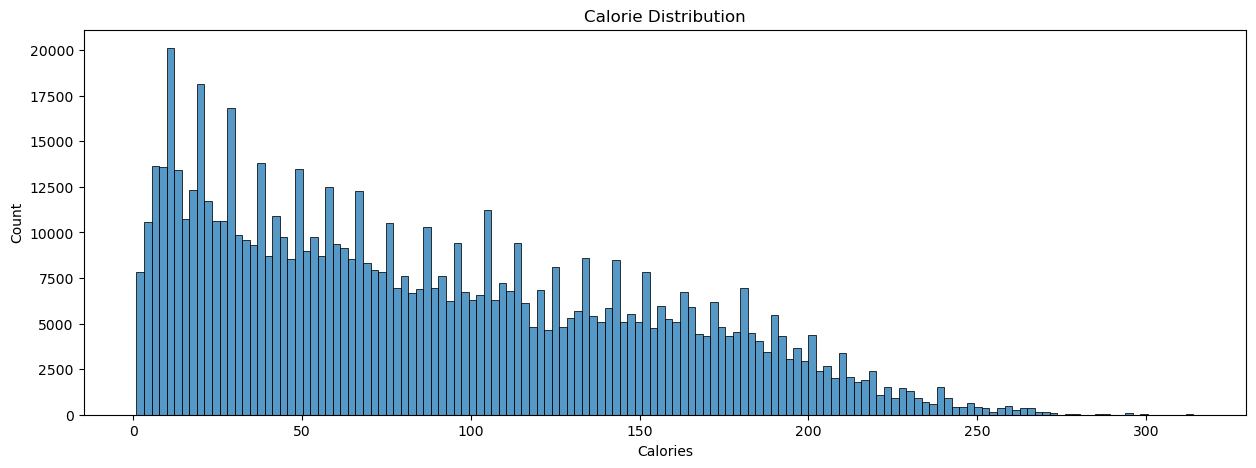

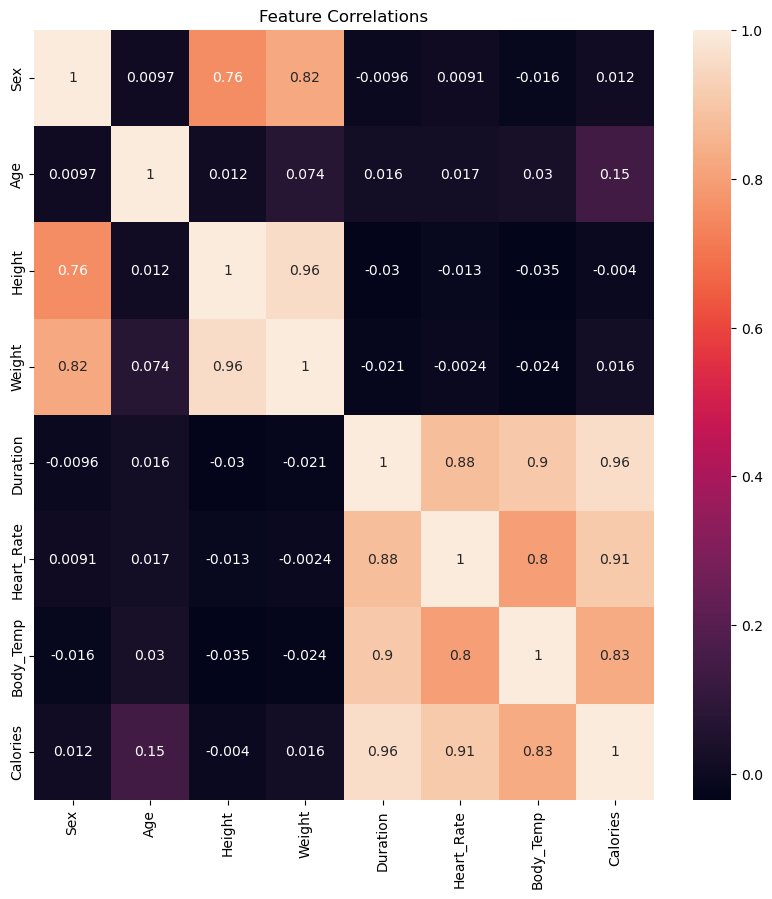

In [79]:
# EDA - check some correlations and scatter plots etc.

# check the distribution of the Calorie information
plt.figure(figsize=(15, 5))
plt.title("Calorie Distribution")
sns.histplot(data=trainData, x="Calories")
plt.show()

# use a heatmap to check correlations between numerical features
plt.figure(figsize=(10, 10))
plt.title("Feature Correlations")
sns.heatmap(trainData.replace({"male":1,"female":0}).corr(), annot=True)
plt.show()

In [80]:
# create some functions we will use

def convertFeatures(data):
    '''
    Function to amend the data to keep feature engineering consistent with training and test data for simple replication
    '''
    # turn the sex column into binary
    data['Sex'] = [1 if a == "male" else 0 for a in data['Sex']]
    # younger people need to workout for longer and at a higher heart rate to as many calories
    data['DHA'] = data['Duration'] * data['Heart_Rate'] * data['Age']
    # smaller mass needs to work out for longer to burn more calories
    data['HW_D'] = (data['Height'] + data['Weight']) * data['Duration']
    # multiply top 3 correlated variables
    data['DHB'] = data['Duration'] * data['Heart_Rate'] * data['Body_Temp']

    # put age into categories
    data['AgeCat'] = pd.cut(data['Age'],
                            bins=[0, 25, 35, 45, 55, 65, 100],
                            labels=['0-25', '25-35', '35-45', '45-55', '55-65', '65+'])
    
    return data

def amendPredictions(predictionList):
    '''
    Amend the model predictions to input some real world adjustments
    - Calories in the training data are all whole int so round to nearest number
    - Put a floor of 1 calorie
    '''
    predictions = [np.round(a) for a in predictionList]
    predictions = [1 if a < 1 else a for a in predictions]
    return predictions

def getRMSLE(predictions, actuals):
    errors = []
    for x, y in zip(actuals, predictions):
        errors.append((np.log(x+1)-np.log(y+1))**2/len(actuals))
    return np.sqrt(sum(errors))

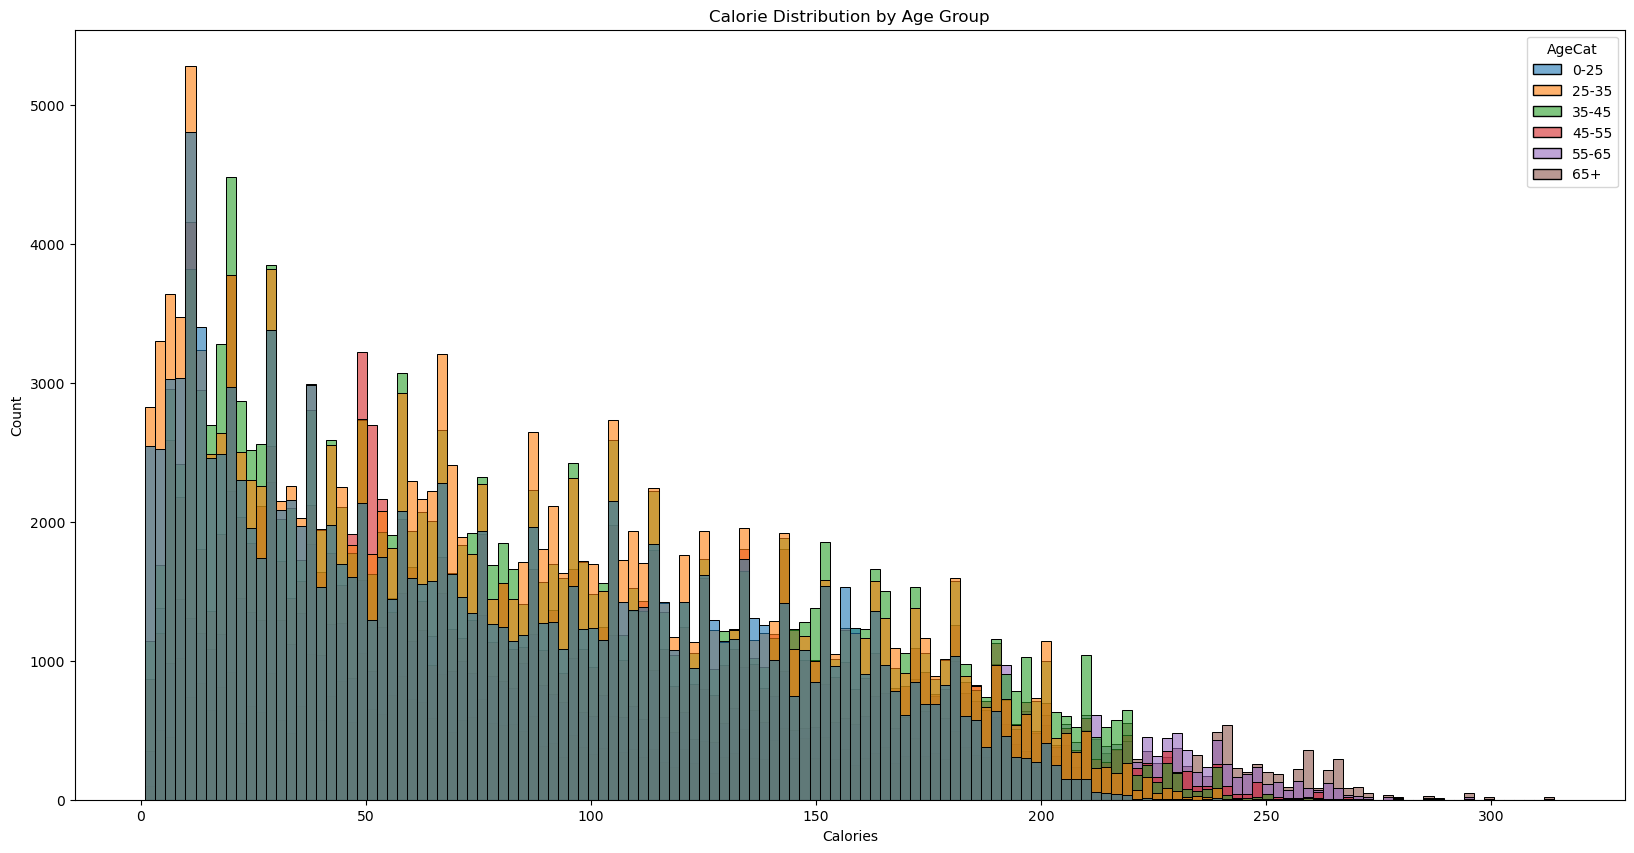

In [81]:
# convert the train and test data into model ready features
trainData = convertFeatures(trainData)
testData = convertFeatures(testData)

# check how the Calorie distributions differ by the new age category feature
plt.figure(figsize=(20, 10))
sns.histplot(data=trainData, x="Calories", hue="AgeCat", alpha=0.6)
plt.title("Calorie Distribution by Age Group")
plt.show()

In [82]:
# convert the Calorie target variable into log1p due to the skewed distribution and RMSLE scoring
trainData['Calories'] = [np.log1p(a) for a in trainData['Calories']]

In [83]:
# prepare the training data for model fitting
seed = 42

categoricalColumns = [
    "AgeCat"
]

X = trainData.drop("Calories", axis=1)
# we will want to make binary dummy variables for the categorical columns
X_Cat = X[categoricalColumns]
# XGBoost can handle unscaled data well so no need to put it through a scaler
X_Num = X.drop(categoricalColumns, axis=1)
X = pd.concat([
    X_Num,
    pd.get_dummies(X_Cat)
], axis=1)
y = trainData[['Calories']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

In [84]:
# Model Tuning

# ROUND 1
#params = {
#    "learning_rate":[0, 0.5, 1],
#    "reg_lambda":[0, 1, 2],
#    "max_depth":[3, 6, 9],
#    "gamma":[0, 0.1, 0.5],
#    "min_child_weight":[1, 5, 10],
#    "subsample":[0.8],
#    "colsample_bytree":[0.8]
#}

#{'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.5, 'max_depth': 6, 'min_child_weight': 1, 'reg_lambda': 2, 'subsample': 0.8}

# ROUND 2
#params = {
#    "learning_rate":[0.5],
#    "reg_lambda":[2, 4, 6],
#    "max_depth":[6],
#    "gamma":[0],
#    "min_child_weight":[0, 0.5, 1],
#    "subsample":[0.8],
#    "colsample_bytree":[0.8]
#}

# {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.5, 'max_depth': 6, 'min_child_weight': 0, 'reg_lambda': 6, 'subsample': 0.8}

#optimalParams = GridSearchCV(estimator=XGBRegressor(random_state=seed), param_grid=params, verbose=2)
#optimalParams.fit(X_train, y_train)
#print(optimalParams.best_params_)

In [85]:
# fit a model with the best hyperparameter values we found
model = XGBRegressor(
    random_state=seed,
    learning_rate=0.5,
    reg_lambda=6,
    max_depth=6,
    gamma=0,
    min_child_weight=0,
    subsample=0.8,
    colsample_bytree=0.8
)
model.fit(X_train, y_train)

# transform the model predictions back using expm1 and then make some real world adjustments
train_pred = amendPredictions(np.expm1(model.predict(X_train)))
test_pred = amendPredictions(np.expm1(model.predict(X_test)))

train_rmsle = getRMSLE(train_pred, np.expm1(y_train.Calories.to_list()))
test_rmsle = getRMSLE(test_pred, np.expm1(y_test.Calories.to_list()))

print(f"Train RMSLE: {train_rmsle}")
print(f"Test RMSLE: {test_rmsle}")

Train RMSLE: 0.06130332922155045
Test RMSLE: 0.06500678752717524


In [86]:
# prepare the test data for model predictions
test_X_cat = testData[categoricalColumns]
test_X_num = testData.drop(categoricalColumns, axis=1)
test_X = pd.concat([
    test_X_num,
    pd.get_dummies(test_X_cat)
], axis=1)

test_X_pred = amendPredictions(np.expm1(model.predict(test_X)))

predictions = pd.DataFrame({
    "id":test_X.index,
    "Calories":test_X_pred
})

# save the file to submit predictionsto kaggle
#predictions.to_csv(r'\submission.csv', index=False)